In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/FCAU.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,3.322368,3.322368,3.322368,3.322368,2.893358,0
1,1/3/2013,3.322368,3.322368,3.322368,3.322368,2.893358,0
2,1/4/2013,3.473684,3.473684,3.473684,3.473684,3.025135,115500
3,1/7/2013,3.486842,3.486842,3.486842,3.486842,3.036594,300
4,1/8/2013,3.486842,3.486842,3.486842,3.486842,3.036594,0


In [3]:
from collections import deque
import random

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed_forward = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, output_size)
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                state = next_state
                X, Y = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 2: buy 1 unit at price 3.473684, total balance 9996.526316
day 3: buy 1 unit at price 3.486842, total balance 9993.039474
day 4, sell 1 unit at price 3.486842, investment 0.378786 %, total balance 9996.526316,
day 5, sell 1 unit at price 3.486842, investment 0.000000 %, total balance 10000.013158,
day 26: buy 1 unit at price 3.855263, total balance 9996.157895
day 27: buy 1 unit at price 3.960526, total balance 9992.197368
day 28, sell 1 unit at price 3.960526, investment 2.730371 %, total balance 9996.157895,
day 29, sell 1 unit at price 4.013158, investment 1.328905 %, total balance 10000.171052,
day 40: buy 1 unit at price 3.473684, total balance 9996.697368
day 41, sell 1 unit at price 3.322368, investment -4.356064 %, total balance 10000.019737,
day 45: buy 1 unit at price 3.750000, total balance 9996.269737
day 46, sell 1 unit at price 3.875000, investment 3.333333 %, total balance 10000.144737,
day 50: buy 1 unit at price 3.796053, total balance 9996.348684
day 51, sell 1 un

day 706: buy 1 unit at price 10.000000, total balance 9992.394736
day 707, sell 1 unit at price 10.026316, investment 0.263157 %, total balance 10002.421052,
day 720: buy 1 unit at price 9.243421, total balance 9993.177631
day 721: buy 1 unit at price 9.177631, total balance 9984.000000
day 722, sell 1 unit at price 8.921053, investment -3.487537 %, total balance 9992.921053,
day 724, sell 1 unit at price 8.894737, investment -3.082431 %, total balance 10001.815790,
day 730: buy 1 unit at price 9.151316, total balance 9992.664474
day 731, sell 1 unit at price 9.217105, investment 0.718905 %, total balance 10001.881579,
day 732: buy 1 unit at price 9.440789, total balance 9992.440790
day 733, sell 1 unit at price 9.375000, investment -0.696861 %, total balance 10001.815790,
day 736: buy 1 unit at price 9.111842, total balance 9992.703948
day 737, sell 1 unit at price 9.236842, investment 1.371841 %, total balance 10001.940790,
day 765: buy 1 unit at price 7.340000, total balance 9994.60

day 1081: buy 1 unit at price 9.970000, total balance 9987.880787
day 1082, sell 1 unit at price 10.220000, investment 2.507523 %, total balance 9998.100787,
day 1084: buy 1 unit at price 10.560000, total balance 9987.540787
day 1085, sell 1 unit at price 10.540000, investment -0.189398 %, total balance 9998.080787,
day 1090: buy 1 unit at price 10.920000, total balance 9987.160787
day 1091, sell 1 unit at price 11.020000, investment 0.915754 %, total balance 9998.180787,
day 1097: buy 1 unit at price 10.870000, total balance 9987.310787
day 1099: buy 1 unit at price 11.140000, total balance 9976.170787
day 1100, sell 1 unit at price 10.930000, investment 0.551982 %, total balance 9987.100787,
day 1101: buy 1 unit at price 10.590000, total balance 9976.510787
day 1102, sell 1 unit at price 10.470000, investment -6.014363 %, total balance 9986.980788,
day 1103, sell 1 unit at price 10.500000, investment -0.849860 %, total balance 9997.480788,
day 1125: buy 1 unit at price 10.710000, tot

day 1483, sell 1 unit at price 15.820000, investment -3.654083 %, total balance 9997.160793,
day 1489: buy 1 unit at price 16.870001, total balance 9980.290792
day 1490, sell 1 unit at price 16.590000, investment -1.659755 %, total balance 9996.880792,
day 1520: buy 1 unit at price 16.520000, total balance 9980.360791
day 1521, sell 1 unit at price 16.620001, investment 0.605329 %, total balance 9996.980792,
day 1525: buy 1 unit at price 16.490000, total balance 9980.490792
day 1526, sell 1 unit at price 16.740000, investment 1.516070 %, total balance 9997.230792,
day 1527: buy 1 unit at price 16.660000, total balance 9980.570792
day 1528, sell 1 unit at price 16.680000, investment 0.120051 %, total balance 9997.250793,
day 1530: buy 1 unit at price 17.209999, total balance 9980.040794
day 1531, sell 1 unit at price 17.160000, investment -0.290524 %, total balance 9997.200793,
day 1539: buy 1 unit at price 14.670000, total balance 9982.530793
day 1540, sell 1 unit at price 14.670000, i

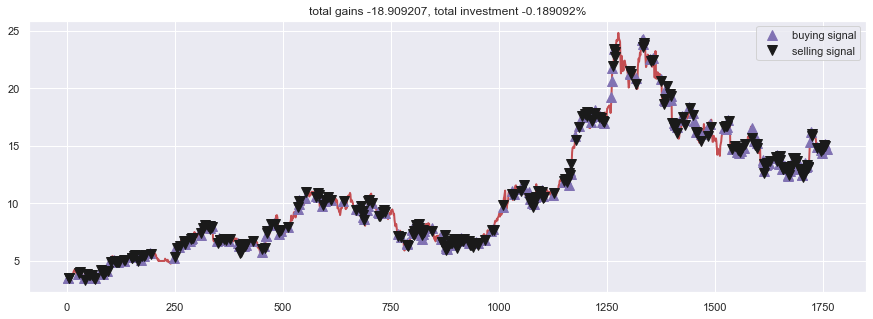

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()